In [ ]:
# This notebook re-trains a version of the DFCI teacher medonc model on a small sample of 100 training notes,
# intentionally overfitting the model to facilitate demonstration of a membership inference attack.

In [2]:
import pandas as pd
import numpy as np
from transformers import AutoTokenizer
import torch
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
device = 'cuda:3'

/homes10/klkehl/miniconda3/envs/llm/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
phi_data = pd.read_csv('/data/clin_notes_outcomes/profile_3-2023/derived_data/labeled_medonc_prissmm_mixedisprog.csv')


In [4]:
training = phi_data[phi_data.split=='train']
training.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32173 entries, 0 to 39190
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0.1              32173 non-null  int64  
 1   dfci_mrn                  32173 non-null  float64
 2   cancer_type               32173 non-null  object 
 3   date                      32173 non-null  object 
 4   any_cancer                32173 non-null  int64  
 5   progression               32173 non-null  int64  
 6   response                  32173 non-null  int64  
 7   Unnamed: 0                32173 non-null  int64  
 8   text                      32173 non-null  object 
 9   PROVIDER_DEPARTMENT       32173 non-null  object 
 10  patient_id                32173 non-null  int64  
 11  hybrid_death_ind          32173 non-null  object 
 12  hybrid_death_dt           19552 non-null  object 
 13  primary_cancer_diagnosis  32173 non-null  object 
 14  genomics_da

In [5]:
training.dfci_mrn.nunique()

2917

In [6]:
validation = phi_data[phi_data.split=='validation']

validation.info()


<class 'pandas.core.frame.DataFrame'>
Index: 3636 entries, 362 to 39187
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0.1              3636 non-null   int64  
 1   dfci_mrn                  3636 non-null   float64
 2   cancer_type               3636 non-null   object 
 3   date                      3636 non-null   object 
 4   any_cancer                3636 non-null   int64  
 5   progression               3636 non-null   int64  
 6   response                  3636 non-null   int64  
 7   Unnamed: 0                3636 non-null   int64  
 8   text                      3636 non-null   object 
 9   PROVIDER_DEPARTMENT       3636 non-null   object 
 10  patient_id                3636 non-null   int64  
 11  hybrid_death_ind          3636 non-null   object 
 12  hybrid_death_dt           2416 non-null   object 
 13  primary_cancer_diagnosis  3636 non-null   object 
 14  genomics_d

In [7]:
test = phi_data[phi_data.split=='test']

test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3382 entries, 57 to 39088
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0.1              3382 non-null   int64  
 1   dfci_mrn                  3382 non-null   float64
 2   cancer_type               3382 non-null   object 
 3   date                      3382 non-null   object 
 4   any_cancer                3382 non-null   int64  
 5   progression               3382 non-null   int64  
 6   response                  3382 non-null   int64  
 7   Unnamed: 0                3382 non-null   int64  
 8   text                      3382 non-null   object 
 9   PROVIDER_DEPARTMENT       3382 non-null   object 
 10  patient_id                3382 non-null   int64  
 11  hybrid_death_ind          3382 non-null   object 
 12  hybrid_death_dt           2160 non-null   object 
 13  primary_cancer_diagnosis  3382 non-null   object 
 14  genomics_da

In [8]:

from transformers import AutoModel



from torch.nn import functional as F
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.nn import LSTM, Linear, Embedding, Conv1d, MaxPool1d, GRU, LSTMCell, Dropout, Module, Sequential, ReLU

   
class LabeledModel(nn.Module):

    def __init__(self, device='cuda'):
        super(LabeledModel, self).__init__()
        self.device = device
        self.longformer = AutoModel.from_pretrained('yikuan8/Clinical-Longformer')
        self.any_cancer_head = Sequential(Linear(768, 128), ReLU(), Linear(128,1))
        self.response_head = Sequential(Linear(768, 128), ReLU(), Linear(128,1))
        self.progression_head = Sequential(Linear(768, 128), ReLU(), Linear(128,1))


        
    def forward(self, x_text_tensor, x_attention_mask):
        # x should be tuple of input IDs, then attention mask
        global_attention_mask = torch.zeros_like(x_text_tensor, device=self.device)
        # global attention on cls token
        global_attention_mask[:, 0] = 1
        main = self.longformer(x_text_tensor, x_attention_mask, global_attention_mask)
        main = main.last_hidden_state[:,0,:].squeeze(1)

                                          
        any_cancer_out = self.any_cancer_head(main)
        response_out = self.response_head(main)
        progression_out = self.progression_head(main)



        
        return any_cancer_out, response_out, progression_out
        




In [9]:
from torch.utils import data

class LabeledDataset(data.Dataset):
    def __init__(self, pandas_dataset):
        self.data = pandas_dataset.copy()
        self.indices = self.data.index.unique()
        self.tokenizer = AutoTokenizer.from_pretrained("yikuan8/Clinical-Longformer", truncation_side='left')        
        
        
    def __len__(self):
        # how many notes in the dataset
        return len(self.indices)
    
    def __getitem__(self, index):
        # get data for notes corresponding to indices passed
        this_index = self.indices[index]
        pand = self.data.loc[this_index, :]
        #label = torch.tensor(pand.progression, dtype=torch.float32)
    
        encoded = self.tokenizer(pand['text'], padding='max_length', truncation=True)

        x_text_tensor = torch.tensor(encoded.input_ids, dtype=torch.long)
        x_attention_mask = torch.tensor(encoded.attention_mask, dtype=torch.long)
        
        y_any_cancer = torch.tensor(pand.any_cancer, dtype=torch.float32)
        y_response = torch.tensor(pand.response, dtype=torch.float32)
        y_progression = torch.tensor(pand.progression, dtype=torch.float32)
        


        return x_text_tensor, x_attention_mask, y_any_cancer, y_response, y_progression
        
        

In [10]:
# train loop
from transformers import get_scheduler
from torch.optim import AdamW, Adam
#, get_linear_schedule_with_warmup


def train_model(model, num_epochs, trainloader, validloader=None, device=device):
    
    

    optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
    num_training_steps = num_epochs * len(trainloader)
    lr_scheduler = get_scheduler(
        name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

    model.to(device)
    
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_train_losses = [0.0 for i in range(3)]
        mean_train_losses = [0.0 for i in range(3)]
        
        running_valid_losses = [0.0 for i in range(3)]
        mean_valid_losses = [0.0 for i in range(3)]

        num_train_batches = len(trainloader)
                
        model.train()
        
        for i, batch in enumerate(trainloader, 0):
            input_ids = batch[0].to(device)
            input_masks = batch[1].to(device)
            
            optimizer.zero_grad()
            
            outputs_true = [x.to(device) for x in batch[2:]]
            
            outputs_pred = model(input_ids, input_masks)
            
           
            losses = [F.binary_cross_entropy_with_logits(outputs_pred[x].squeeze(1), outputs_true[x]) for x in range(3)]
            
            total_loss = 0.0
            for j in range(3):
                total_loss = total_loss + losses[j]

                
            total_loss.backward()
            optimizer.step()
            lr_scheduler.step()
            
            
            for j in range(3):
                running_train_losses[j] += losses[j].detach().cpu().numpy()
                mean_train_losses[j] = running_train_losses[j] / (i+1)
                
            print('Training Epoch: ' + str(epoch+1) + ', batch: ' + str(i + 1) + '/' + str(num_train_batches) + ' this_loss:' + str(total_loss.detach().cpu().numpy()) +', train losses: ' + str([str(x) + ': ' + str(mean_train_losses[x]) + ", " for x in range(3)]), end='\r', flush=True)
        
        print('\n')
        # eval on valid
        
        if validloader is not None:
            num_valid_batches = len(validloader)
            model.eval()
            
            for i, batch in enumerate(validloader, 0):
                input_ids = batch[0].to(device)
                input_masks = batch[1].to(device)


                outputs_true = [x.to(device) for x in batch[2:]]

                outputs_pred = model(input_ids, input_masks)

                losses = [F.binary_cross_entropy_with_logits(outputs_pred[x].squeeze(1), outputs_true[x]) for x in range(3)]

                total_loss = 0.0
                for j in range(3):
                    total_loss = total_loss + losses[j]
                


                for j in range(3):
                    running_valid_losses[j] += losses[j].detach().cpu().numpy()

            
            for j in range(3):
                mean_valid_losses[j] = running_valid_losses[j] / (i+1)
            

            
            print('Validation Epoch: ' + str(epoch+1) + ', batch: ' + str(i + 1) + '/' + str(num_valid_batches) + ', valid losses: ' + str([str(x) + ': ' + str(mean_valid_losses[x]) + ", " for x in range(3)]), end='\r', flush=True)
            print('\n')

    

In [11]:
training.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32173 entries, 0 to 39190
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0.1              32173 non-null  int64  
 1   dfci_mrn                  32173 non-null  float64
 2   cancer_type               32173 non-null  object 
 3   date                      32173 non-null  object 
 4   any_cancer                32173 non-null  int64  
 5   progression               32173 non-null  int64  
 6   response                  32173 non-null  int64  
 7   Unnamed: 0                32173 non-null  int64  
 8   text                      32173 non-null  object 
 9   PROVIDER_DEPARTMENT       32173 non-null  object 
 10  patient_id                32173 non-null  int64  
 11  hybrid_death_ind          32173 non-null  object 
 12  hybrid_death_dt           19552 non-null  object 
 13  primary_cancer_diagnosis  32173 non-null  object 
 14  genomics_da

In [12]:
sample_train = training.sample(100, random_state=42)

In [13]:
#from torch.nn import DataParallel

themodel = LabeledModel(device='cuda:3')
# #net = DataParallel(themodel, device_ids=[0,1])
trainloader = data.DataLoader(LabeledDataset(sample_train.reset_index(drop=True)), batch_size=4, num_workers=8, shuffle=True)
validloader = data.DataLoader(LabeledDataset(validation.reset_index(drop=True)), batch_size=4, num_workers=8, shuffle=True)
train_model(themodel,20, trainloader, device=device)

Some weights of LongformerModel were not initialized from the model checkpoint at yikuan8/Clinical-Longformer and are newly initialized: ['longformer.pooler.dense.bias', 'longformer.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training Epoch: 1, batch: 25/25 this_loss:0.65341175, train losses: ['0: 0.5965551972389221, ', '1: 0.5652674698829651, ', '2: 0.4734981679916382, ']

Training Epoch: 2, batch: 25/25 this_loss:1.865369, train losses: ['0: 0.5251971316337586, ', '1: 0.4768485713005066, ', '2: 0.3294762146472931, ']]']

Training Epoch: 3, batch: 25/25 this_loss:1.0942973, train losses: ['0: 0.5209505128860473, ', '1: 0.4703572118282318, ', '2: 0.33894161343574525, ']]

Training Epoch: 4, batch: 25/25 this_loss:1.1061248, train losses: ['0: 0.5160759854316711, ', '1: 0.46627450346946714, ', '2: 0.32504243731498716, ']]

Training Epoch: 5, batch: 25/25 this_loss:1.6510634, train losses: ['0: 0.49688378751277923, ', '1: 0.4259934478998184, ', '2: 0.3129593098163605, ']']

Training Epoch: 6, batch: 25/25 this_loss:1.7288257, train losses: ['0: 0.47895416855812073, ', '1: 0.3501133865118027, ', '2: 0.29511929214000704, ']]

Training Epoch: 7, batch: 25/25 this_loss:0.88550925, train losses: ['0: 0.45862628340

In [14]:
torch.save(themodel.state_dict(), 'dfci_phi_note_longformer_overfit_small_train.pt')

In [16]:
# write out actual validation dataset
themodel = LabeledModel(device = device)
themodel.load_state_dict(torch.load('dfci_phi_note_longformer_overfit_small_train.pt'))
themodel.to(device)

themodel.eval()

no_shuffle_valid_dataset = data.DataLoader(LabeledDataset(validation), batch_size=4, shuffle=False, num_workers=0)

output_true_lists = [[] for x in range(3)]
output_prediction_lists = [[] for x in range(3)]
for batch in no_shuffle_valid_dataset:
    #thisframe = pd.DataFrame()
    x_text_ids = batch[0].to(device)
    x_attention_mask = batch[1].to(device)
    with torch.no_grad():
        predictions = themodel(x_text_ids, x_attention_mask)
    for j in range(3):
        output_true_lists[j].append(batch[2+j].detach().cpu().numpy())
        output_prediction_lists[j].append(predictions[j].detach().cpu().numpy())

output_true_lists = [np.concatenate(x) for x in output_true_lists]        
output_prediction_lists = [np.concatenate(x) for x in output_prediction_lists]


output_validation = validation.copy()
for x in range(3):
    output_validation['outcome_' + str(x) + '_logit'] = output_prediction_lists[x]



Some weights of LongformerModel were not initialized from the model checkpoint at yikuan8/Clinical-Longformer and are newly initialized: ['longformer.pooler.dense.bias', 'longformer.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
from sklearn.metrics import roc_auc_score


In [19]:
[print(roc_auc_score(output_true_lists[x], output_prediction_lists[x])) for x in range(3)]

0.5790078062995297
0.4839591068782364
0.5275640799651339


[None, None, None]

In [20]:
from utils_102023 import *

AUC 0.5790078062995297
Outcome probability: 0.8006050605060506
Average precision score: 0.85
Best F1: 0.8892622575225294


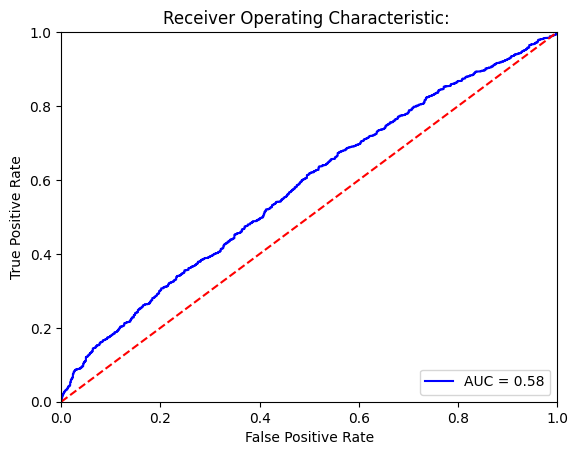

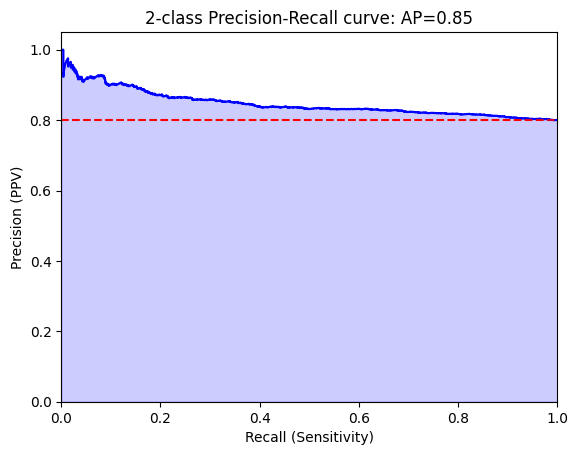

Threshold for best F1:
-2.1914272
Confusion matrix at best F1 thresh:
Confusion matrix, without normalization
[[   0  725]
 [   0 2911]]


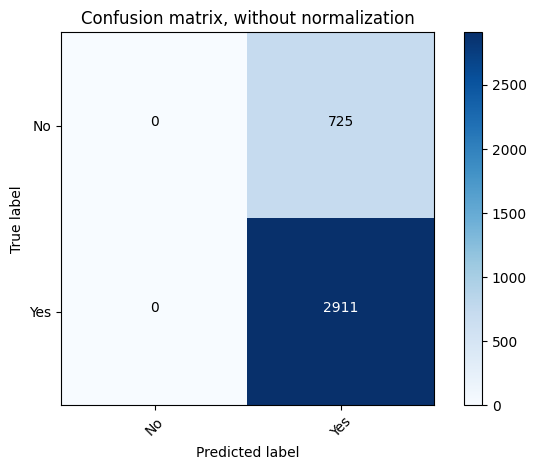

Metrics at best F1 thresh (specificity is recall for negative class):
              precision    recall  f1-score   support

          No       0.00      0.00      0.00       725
         Yes       0.80      1.00      0.89      2911

    accuracy                           0.80      3636
   macro avg       0.40      0.50      0.44      3636
weighted avg       0.64      0.80      0.71      3636

Confusion matrix at 0.5 thresh:
Confusion matrix, without normalization
[[  48  677]
 [ 144 2767]]


/homes10/klkehl/miniconda3/envs/llm/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/homes10/klkehl/miniconda3/envs/llm/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/homes10/klkehl/miniconda3/envs/llm/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

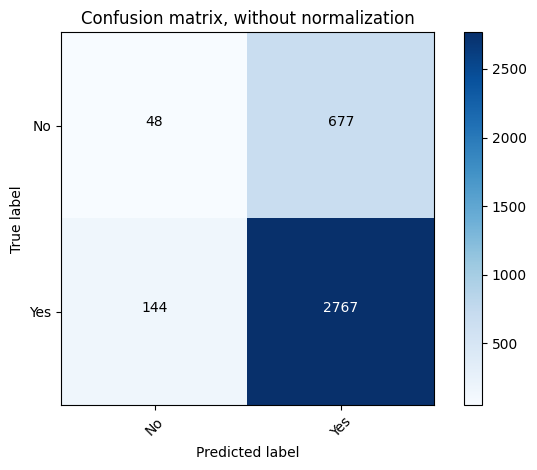

Metrics at 0.5 thresh thresh (specificity is recall for negative class):
              precision    recall  f1-score   support

          No       0.25      0.07      0.10       725
         Yes       0.80      0.95      0.87      2911

    accuracy                           0.77      3636
   macro avg       0.53      0.51      0.49      3636
weighted avg       0.69      0.77      0.72      3636



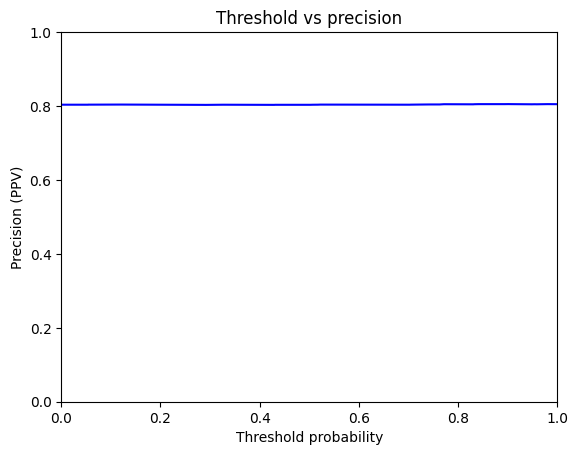

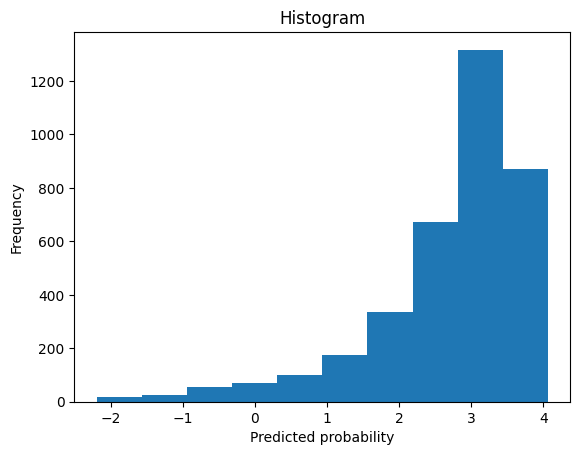

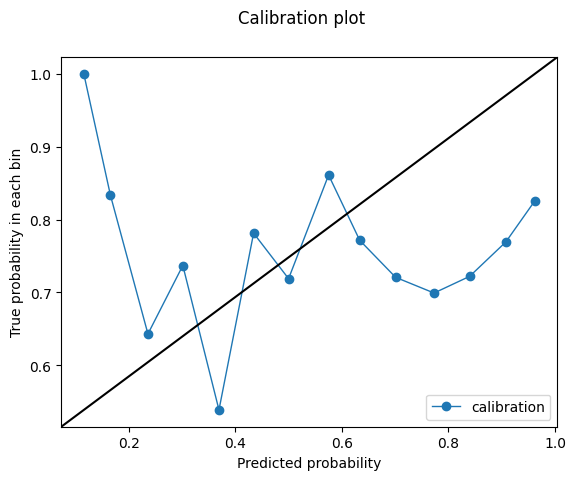

-2.1914272

In [21]:
eval_model(output_prediction_lists[0], output_true_lists[0], graph=True)

AUC 0.4839591068782364
Outcome probability: 0.13063806380638063
Average precision score: 0.13
Best F1: 0.23377934864933098


/data/clin_notes_outcomes/impression_bert/medonc/code/utils_102023.py:111: RuntimeWarning: invalid value encountered in divide
  F1 = 2*((precision*recall)/(precision+recall))


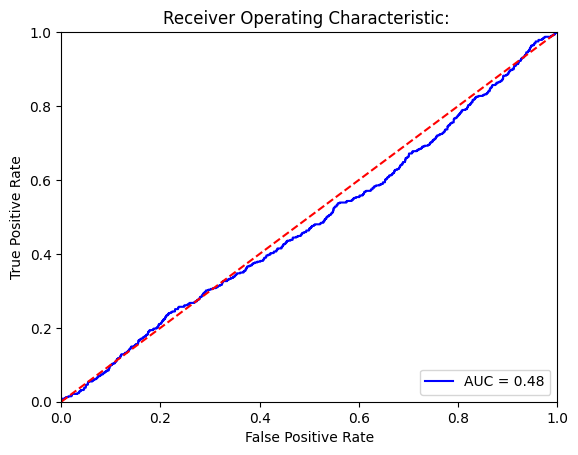

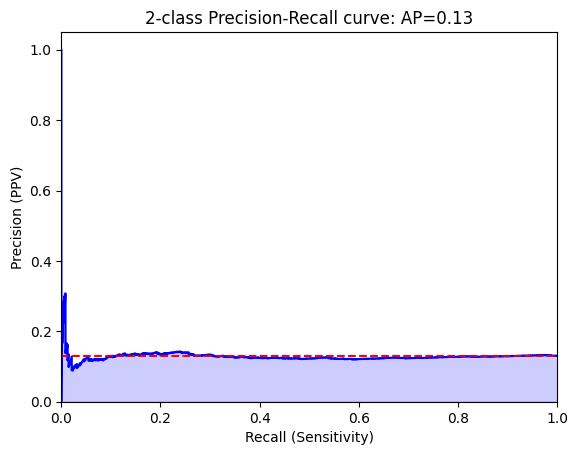

Threshold for best F1:
2.4959838
Confusion matrix at best F1 thresh:
Confusion matrix, without normalization
[[3158    3]
 [ 475    0]]


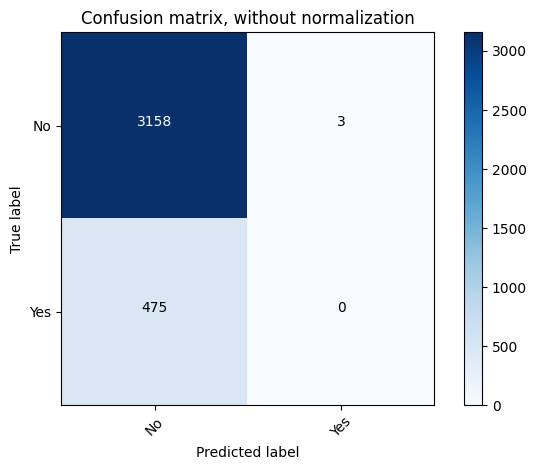

Metrics at best F1 thresh (specificity is recall for negative class):
              precision    recall  f1-score   support

          No       0.87      1.00      0.93      3161
         Yes       0.00      0.00      0.00       475

    accuracy                           0.87      3636
   macro avg       0.43      0.50      0.46      3636
weighted avg       0.76      0.87      0.81      3636

Confusion matrix at 0.5 thresh:
Confusion matrix, without normalization
[[2872  289]
 [ 435   40]]


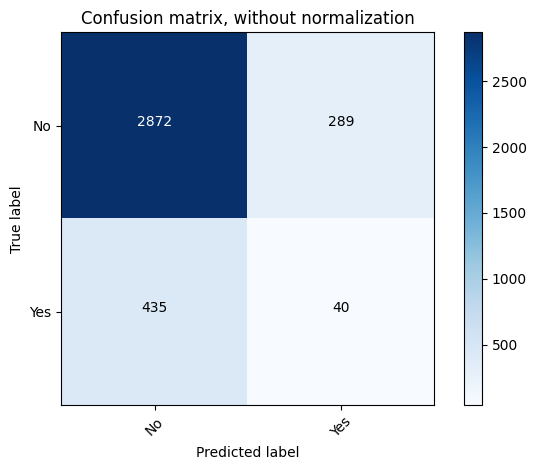

Metrics at 0.5 thresh thresh (specificity is recall for negative class):
              precision    recall  f1-score   support

          No       0.87      0.91      0.89      3161
         Yes       0.12      0.08      0.10       475

    accuracy                           0.80      3636
   macro avg       0.50      0.50      0.49      3636
weighted avg       0.77      0.80      0.79      3636



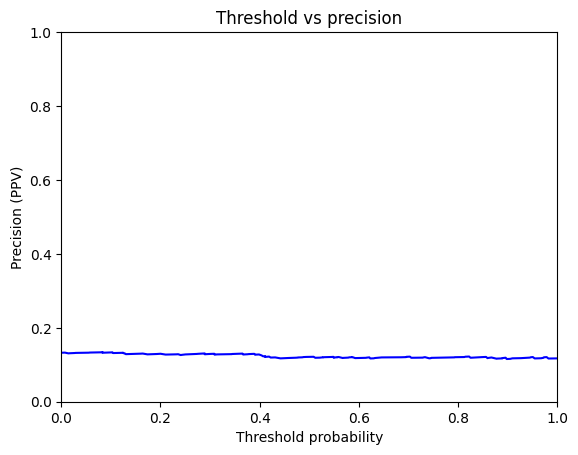

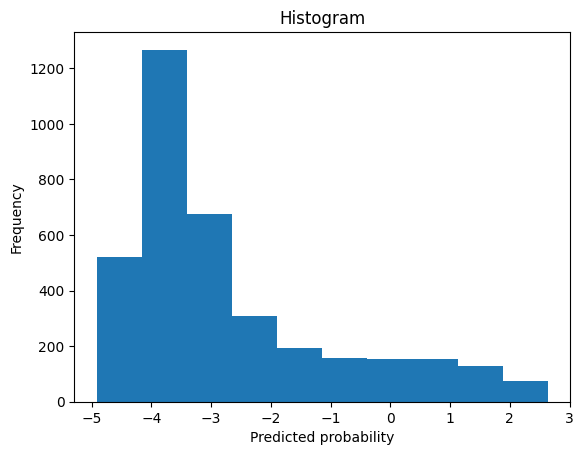

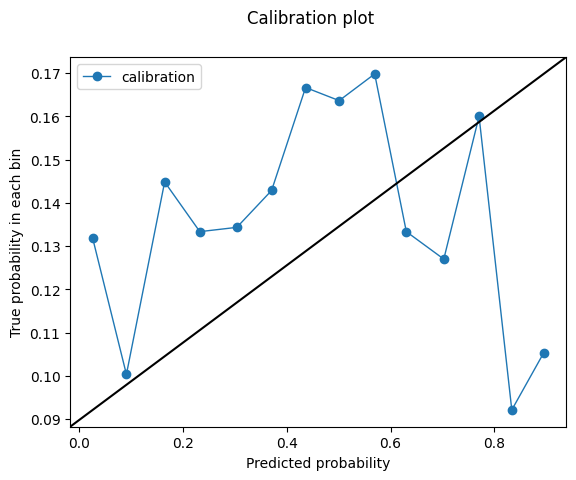

2.4959838

In [22]:
eval_model(output_prediction_lists[1], output_true_lists[1], graph=True)

AUC 0.5275640799651339
Outcome probability: 0.1806930693069307
Average precision score: 0.21
Best F1: 0.3064365671641791


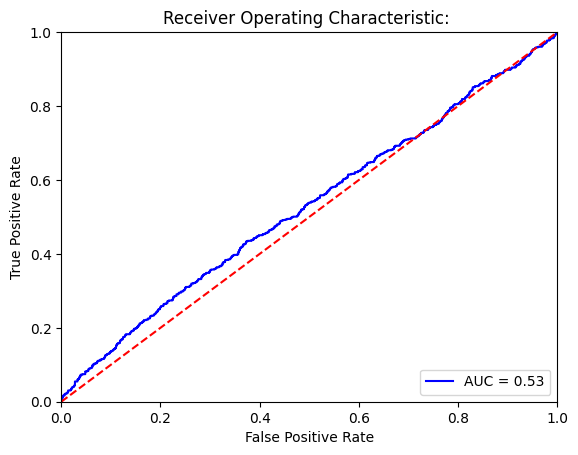

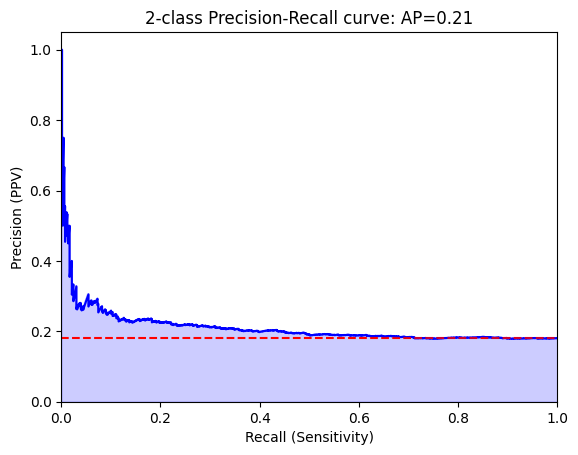

Threshold for best F1:
-4.9129143
Confusion matrix at best F1 thresh:
Confusion matrix, without normalization
[[   5 2974]
 [   0  657]]


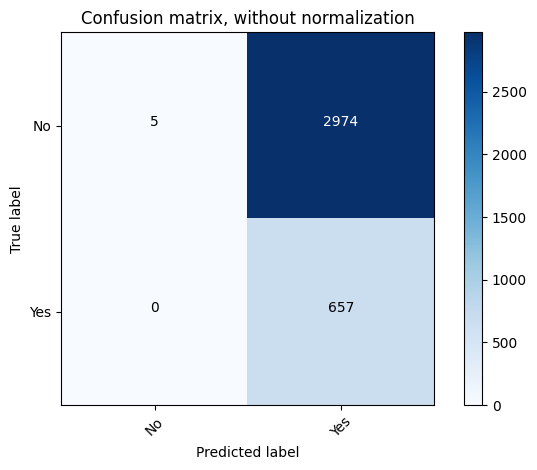

Metrics at best F1 thresh (specificity is recall for negative class):
              precision    recall  f1-score   support

          No       1.00      0.00      0.00      2979
         Yes       0.18      1.00      0.31       657

    accuracy                           0.18      3636
   macro avg       0.59      0.50      0.15      3636
weighted avg       0.85      0.18      0.06      3636

Confusion matrix at 0.5 thresh:
Confusion matrix, without normalization
[[2968   11]
 [ 646   11]]


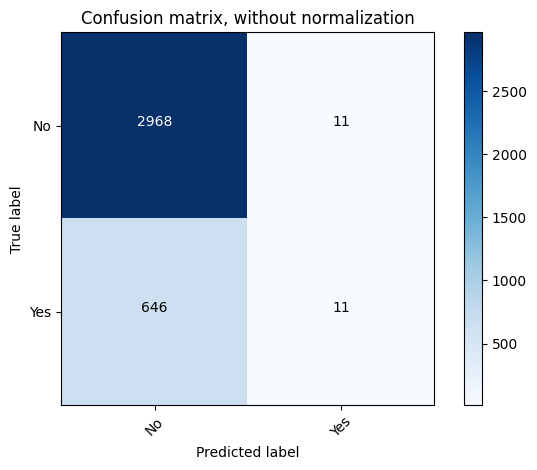

Metrics at 0.5 thresh thresh (specificity is recall for negative class):
              precision    recall  f1-score   support

          No       0.82      1.00      0.90      2979
         Yes       0.50      0.02      0.03       657

    accuracy                           0.82      3636
   macro avg       0.66      0.51      0.47      3636
weighted avg       0.76      0.82      0.74      3636



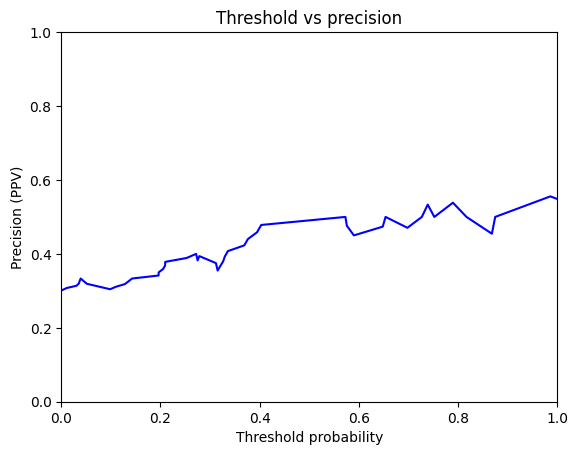

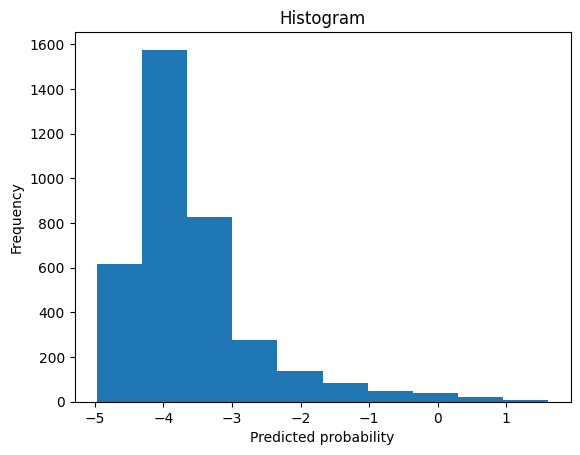

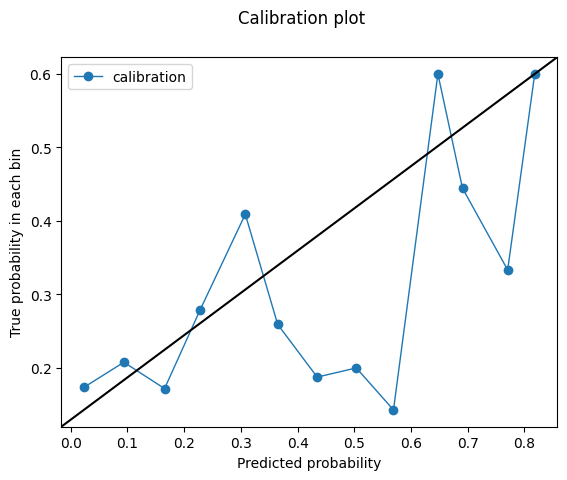

-4.9129143

In [23]:
eval_model(output_prediction_lists[2], output_true_lists[2], graph=True)

In [26]:
# write out actual training dataset
themodel = LabeledModel(device=device)
themodel.load_state_dict(torch.load('dfci_phi_note_longformer_overfit_small_train.pt'))
themodel.to(device)

themodel.eval()

no_shuffle_valid_dataset = data.DataLoader(LabeledDataset(sample_train), batch_size=4, shuffle=False, num_workers=0)

output_true_lists = [[] for x in range(3)]
output_prediction_lists = [[] for x in range(3)]
for batch in no_shuffle_valid_dataset:
    #thisframe = pd.DataFrame()
    x_text_ids = batch[0].to(device)
    x_attention_mask = batch[1].to(device)
    with torch.no_grad():
        predictions = themodel(x_text_ids, x_attention_mask)
    for j in range(3):
        output_true_lists[j].append(batch[2+j].detach().cpu().numpy())
        output_prediction_lists[j].append(predictions[j].detach().cpu().numpy())

output_true_lists = [np.concatenate(x) for x in output_true_lists]        
output_prediction_lists = [np.concatenate(x) for x in output_prediction_lists]
output_validation = sample_train.copy()
for x in range(3):
    output_validation['outcome_' + str(x) + '_logit'] = output_prediction_lists[x]

Some weights of LongformerModel were not initialized from the model checkpoint at yikuan8/Clinical-Longformer and are newly initialized: ['longformer.pooler.dense.bias', 'longformer.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# demonstrate perfect performance on training data (overfit teacher model has memorized training data)

In [28]:
from sklearn.metrics import roc_auc_score


In [29]:
[print(roc_auc_score(output_true_lists[x], output_prediction_lists[x])) for x in range(3)]

1.0
1.0
1.0


[None, None, None]

In [30]:
from utils_102023 import *

AUC 1.0
Outcome probability: 0.79
Average precision score: 1.00
Best F1: 1.0


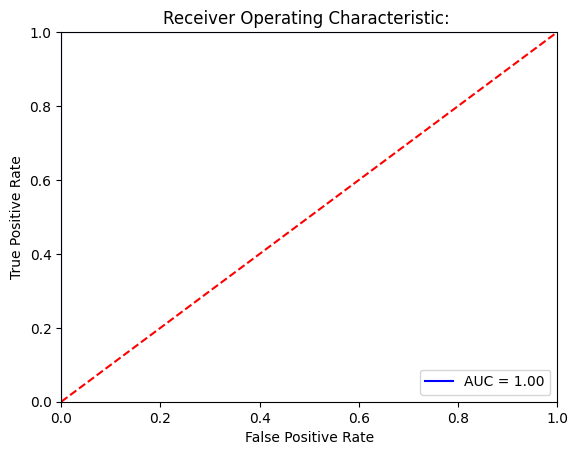

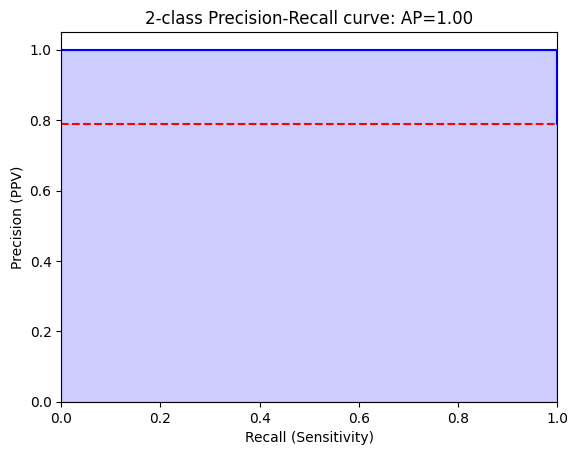

Threshold for best F1:
1.8810861
Confusion matrix at best F1 thresh:
Confusion matrix, without normalization
[[21  0]
 [ 0 79]]


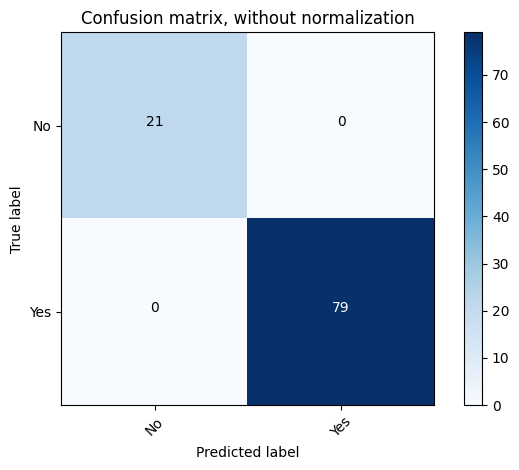

Metrics at best F1 thresh (specificity is recall for negative class):
              precision    recall  f1-score   support

          No       1.00      1.00      1.00        21
         Yes       1.00      1.00      1.00        79

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100

Confusion matrix at 0.5 thresh:
Confusion matrix, without normalization
[[21  0]
 [ 0 79]]


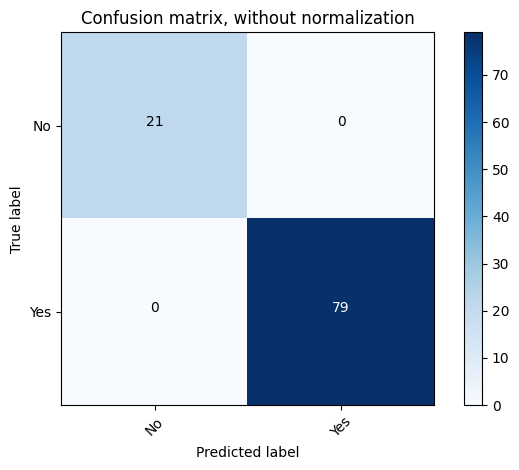

Metrics at 0.5 thresh thresh (specificity is recall for negative class):
              precision    recall  f1-score   support

          No       1.00      1.00      1.00        21
         Yes       1.00      1.00      1.00        79

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100



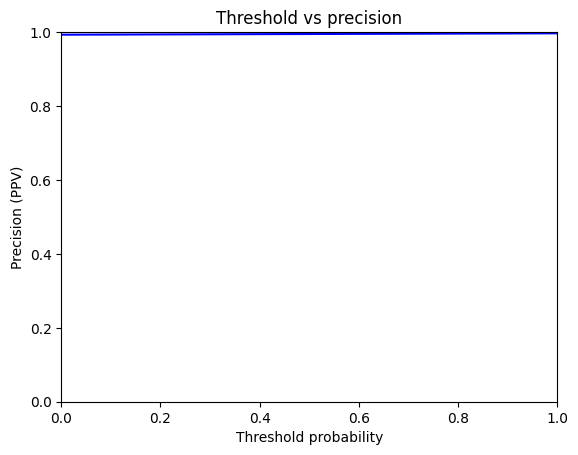

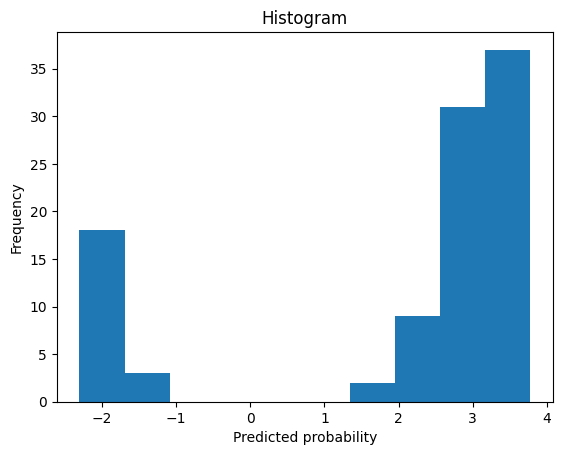

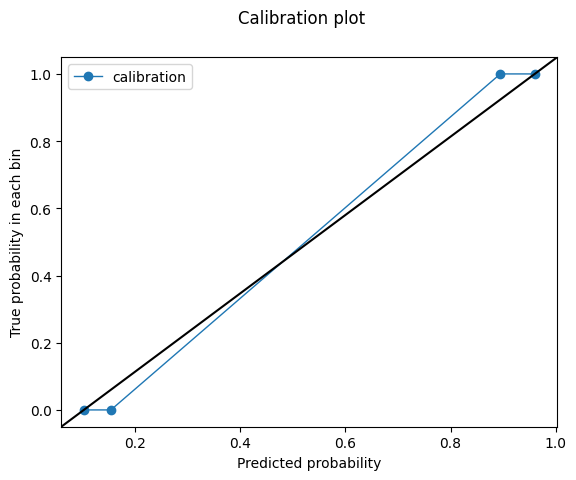

1.8810861

In [31]:
eval_model(output_prediction_lists[0], output_true_lists[0], graph=True)

AUC 1.0
Outcome probability: 0.18
Average precision score: 1.00
Best F1: 1.0


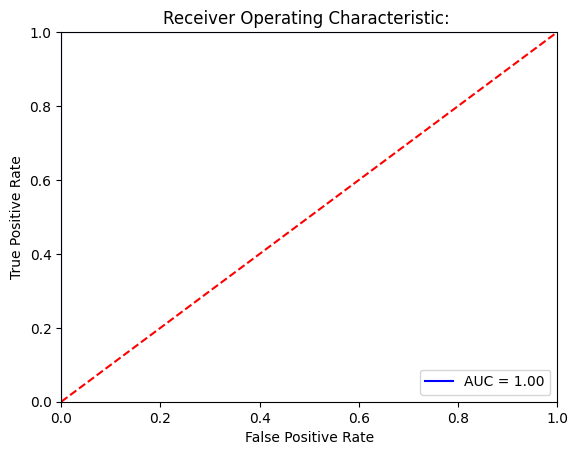

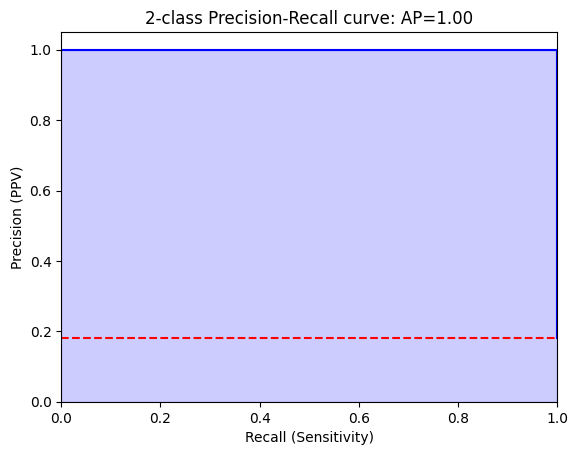

Threshold for best F1:
2.5018046
Confusion matrix at best F1 thresh:
Confusion matrix, without normalization
[[82  0]
 [ 0 18]]


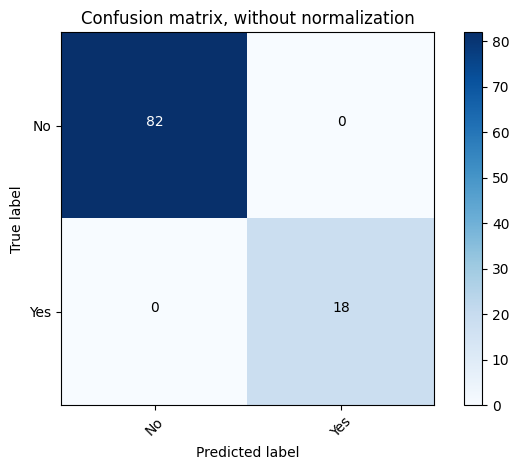

Metrics at best F1 thresh (specificity is recall for negative class):
              precision    recall  f1-score   support

          No       1.00      1.00      1.00        82
         Yes       1.00      1.00      1.00        18

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100

Confusion matrix at 0.5 thresh:
Confusion matrix, without normalization
[[82  0]
 [ 0 18]]


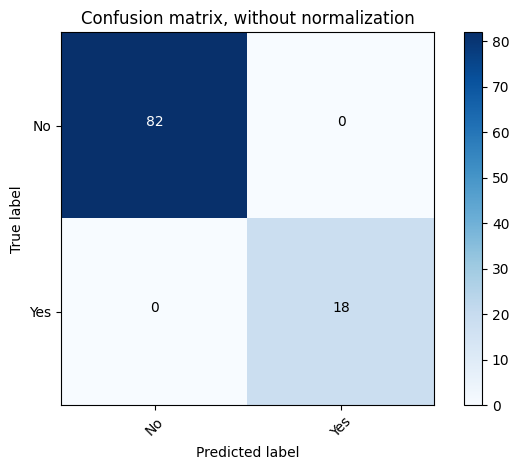

Metrics at 0.5 thresh thresh (specificity is recall for negative class):
              precision    recall  f1-score   support

          No       1.00      1.00      1.00        82
         Yes       1.00      1.00      1.00        18

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100



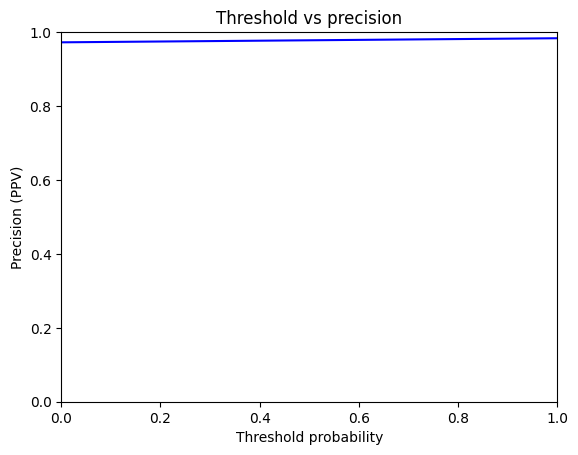

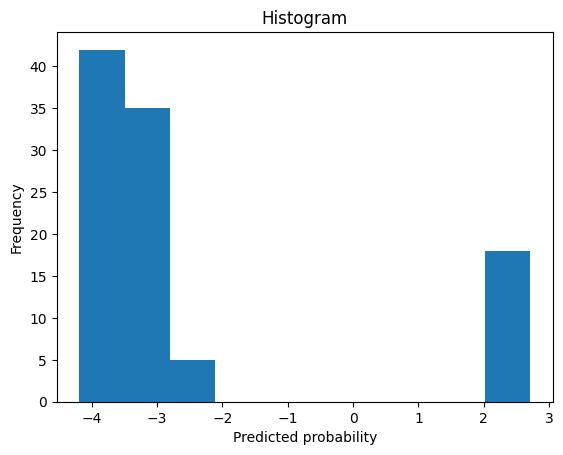

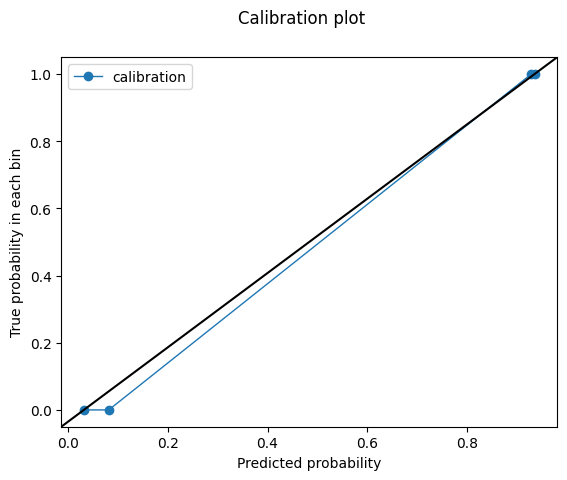

2.5018046

In [32]:
eval_model(output_prediction_lists[1], output_true_lists[1], graph=True)

AUC 1.0
Outcome probability: 0.1
Average precision score: 1.00
Best F1: 1.0


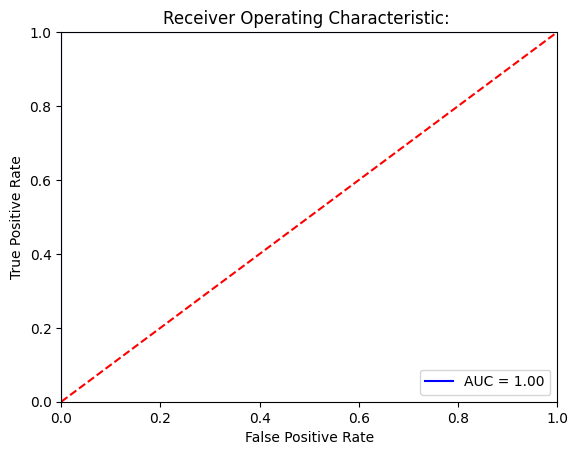

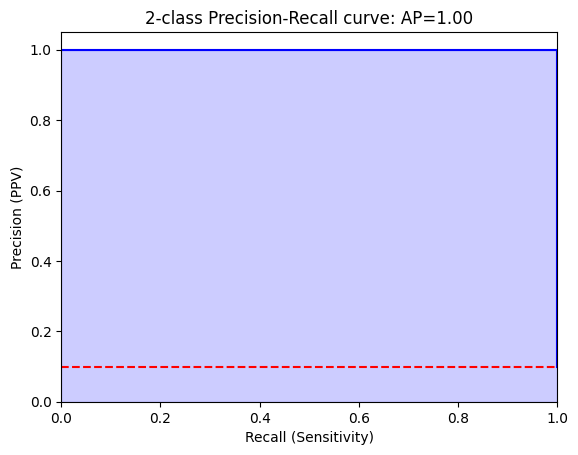

Threshold for best F1:
1.4947283
Confusion matrix at best F1 thresh:
Confusion matrix, without normalization
[[90  0]
 [ 0 10]]


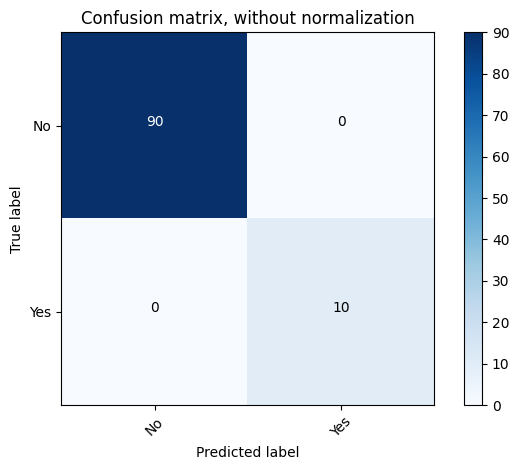

Metrics at best F1 thresh (specificity is recall for negative class):
              precision    recall  f1-score   support

          No       1.00      1.00      1.00        90
         Yes       1.00      1.00      1.00        10

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100

Confusion matrix at 0.5 thresh:
Confusion matrix, without normalization
[[90  0]
 [ 0 10]]


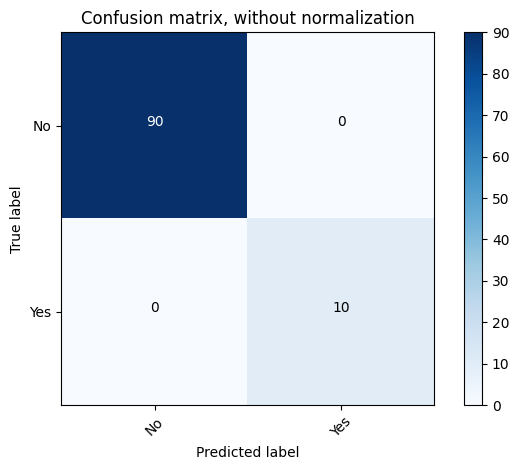

Metrics at 0.5 thresh thresh (specificity is recall for negative class):
              precision    recall  f1-score   support

          No       1.00      1.00      1.00        90
         Yes       1.00      1.00      1.00        10

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100



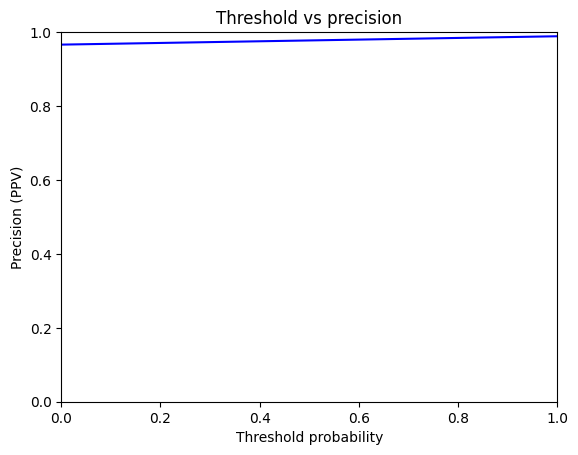

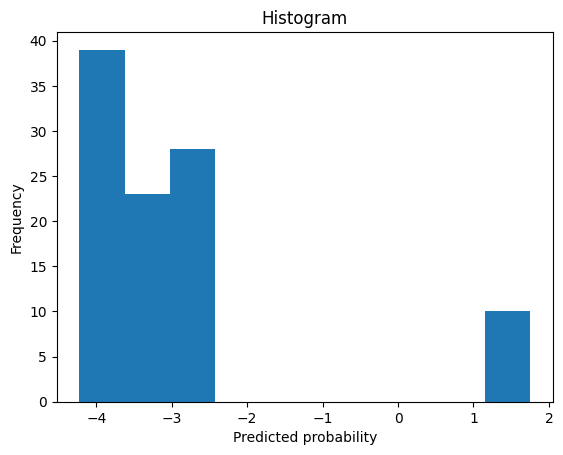

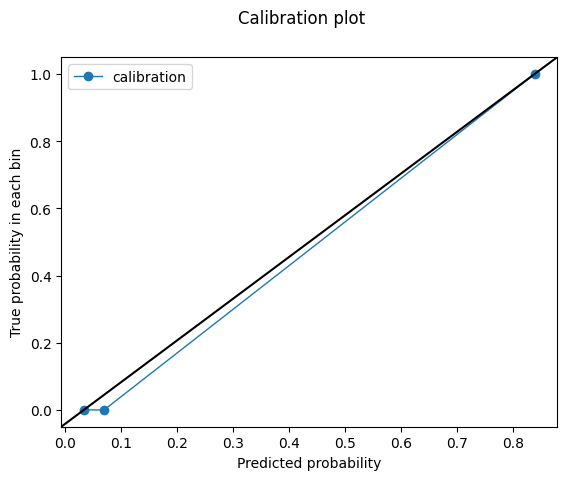

1.4947283

In [33]:
eval_model(output_prediction_lists[2], output_true_lists[2], graph=True)